# Annotations: Explanatory Data Analysis

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, OrderedDict
import cv2
from PIL import Image

In [3]:
mpl.rcParams.update({'font.size': 14})
CMAP = plt.get_cmap('rainbow')

In [4]:
IMAGES_PATH = Path(r'sampled_frames')
ANNOTATIONS = (r'annotation_data/Default-Project27Jul2019_17h55m13s_export.csv',
               r'annotation_data/Default-Project15Aug2019_00h37m32s_export.csv',
               r'annotation_data/Default-Project18Aug2019_01h58m55s_export.csv')
OUT_PATH = Path(r'annotation_data/annotations.pkl')

## EDA

In [5]:
data = pd.concat([pd.read_csv(f, skiprows=9) for f in ANNOTATIONS])
data = pd.DataFrame({
    'file': [f[2:-2] for f in data['file_list']],
    'x': [ float(sc[1:-1].split(',')[1]) for sc in data['spatial_coordinates'] ],
    'y': [ float(sc[1:-1].split(',')[2]) for sc in data['spatial_coordinates'] ],
    'dx': [ float(sc[1:-1].split(',')[3]) for sc in data['spatial_coordinates'] ],
    'dy': [ float(sc[1:-1].split(',')[4]) for sc in data['spatial_coordinates'] ]
})

# y,x,dy,dx -> y1,x1,y2,x2
data['y1'] = data['y']
data['x1'] = data['x']
data['y2'] = data['y'] + data['dy']
data['x2'] = data['x'] + data['dx']

print(data.shape)
data.head()

(800, 9)


,file,x,y,dx,dy,y1,x1,y2,x2
0,20190520_105429_1080.png,411.896,619.069,36.776,20.840,619.069,411.896,639.909,448.672
1,20190520_105429_1080.png,197.367,608.036,57.616,42.906,608.036,197.367,650.942,254.983
2,20190520_105429_1080.png,89.489,620.295,71.101,36.777,620.295,89.489,657.072,160.590
3,20190520_105429_1080.png,85.812,655.846,46.583,18.388,655.846,85.812,674.234,132.395
4,20190520_105429_1080.png,51.487,673.008,58.842,22.066,673.008,51.487,695.074,110.329


In [6]:
invalid_size = np.logical_or(data.dx<=0, data.dy<=0)
print(f'Boxes with invalid size: {np.sum(invalid_size):d}')
data = data[np.logical_not(invalid_size)]

Boxes with invalid size: 5


In [7]:
print(f'Boxes with invalid position: {(data.x<0).sum()+(data.y<0).sum():d}')
data.loc[data.x<0, 'x'] = 0
data.loc[data.y<0, 'y'] = 0

Boxes with invalid position: 5


In [8]:
files = list(np.unique(data.file))
print(f'{len(files):d} files')
files[:3]

14 files


['20190520_105429_1080.png',
 '20190520_232200_0.png',
 '20190522_194812_580.png']

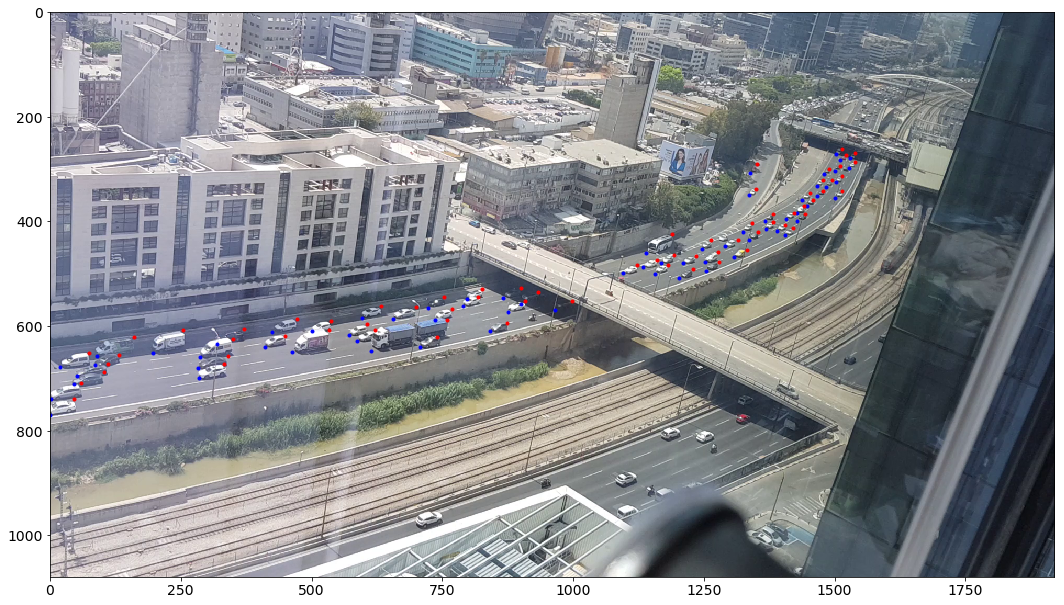

In [9]:
image = Image.open(IMAGES_PATH/files[0])
ids = data.file == files[0]

plt.figure(figsize=(18,12))
plt.imshow(image)
plt.plot(data.x[ids],              data.y[ids]+data.dy[ids], 'b.')
plt.plot(data.x[ids]+data.dx[ids], data.y[ids],              'r.');

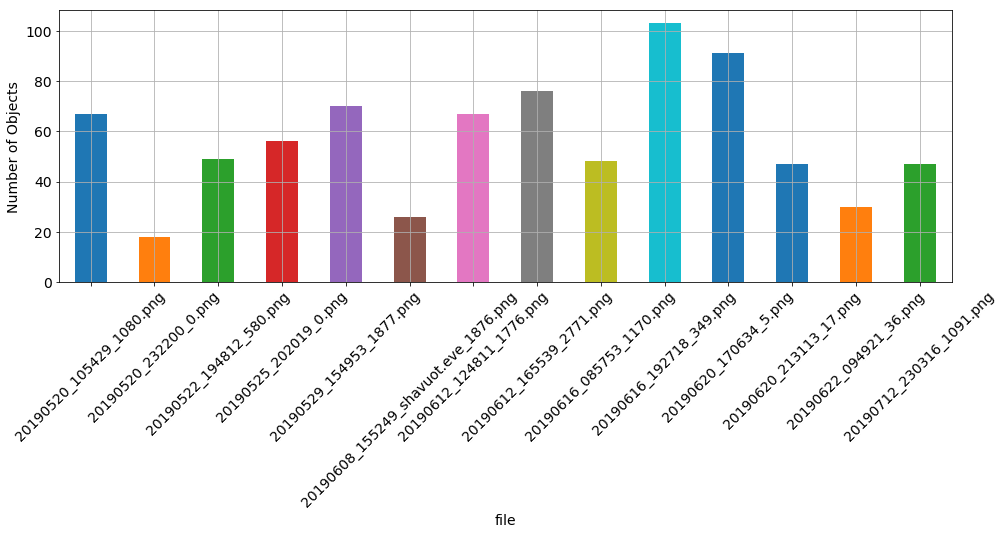

In [10]:
plt.figure(figsize=(16,5))
data.groupby('file').apply(lambda d: len(d)).plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of Objects')
plt.grid()

It can be seen that in older videos (before 25/5) the camera was positioned slightly differently, thus the recorded objects are positioned differently. In addition, specifically in the 25/5, the positioning was significantly different:

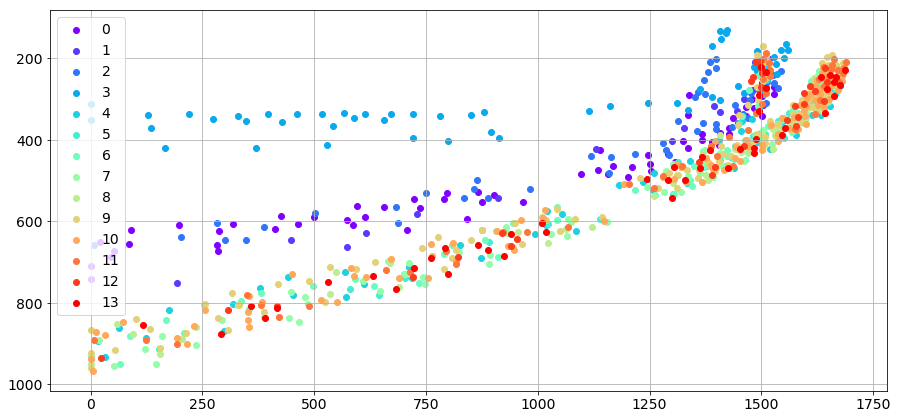

In [11]:
# plot all cars locations per image

COLORS = [CMAP(i)[:3] for i in np.linspace(0, 1, len(files))]
plt.figure(figsize=(15,7))

for i,f in enumerate(files):
    plt.scatter(data.x[data.file==f], data.y[data.file==f], color=COLORS[i], label=i)
plt.gca().invert_yaxis()
plt.grid()
plt.legend();

Most vehicles are of size 20-50 pixels (i.e. 400-2500 pixels^2), mostly depending on their distance from the camera (vehicles in the left of the image are closer):

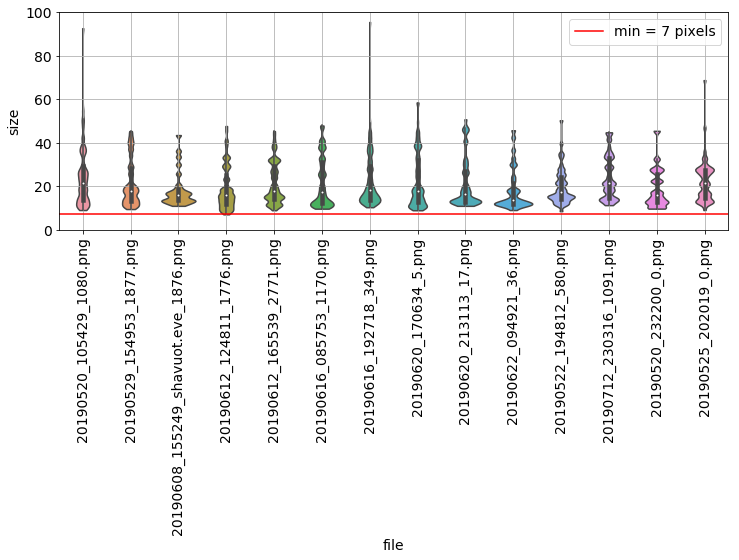

In [12]:
data['size'] = np.sqrt(data.dx * data.dy)

plt.figure(figsize=(12,4))
sns.violinplot('file', 'size', data=data, bw=0.1, cut=0)
plt.axhline(np.min(data['size']), color='r', label=f'min = {np.min(data["size"]):.0f} pixels')
plt.xticks(rotation=90)
plt.ylim((0,None))
plt.grid()
plt.legend();

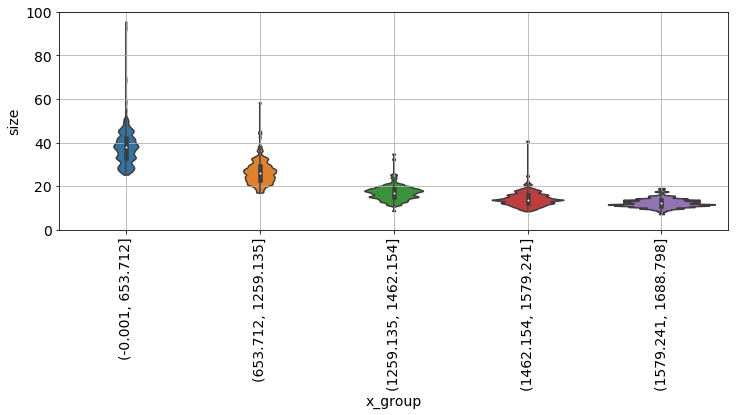

In [13]:
data['x_group'] = pd.qcut(data.x, 5)
plt.figure(figsize=(12,4))
sns.violinplot('x_group', 'size', data=data, bw=0.1, cut=0)
plt.xticks(rotation=90)
plt.ylim((0,None))
plt.grid()

In [14]:
data.to_pickle(OUT_PATH)